In [1]:
from descriptive_statistics import DiabetesDataBase
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from utils import grid_search, halving_random_search, validate
import numpy as np

## Hyperparameters

In [9]:
#SCALER = StandardScaler()
SCALER = RobustScaler() # No difference to standard scaler for models I test except mlp
#SCALER = QuantileTransformer(n_quantiles=334) # Slightly better result for regression and SVM
RANDOM_STATE = 17

## Tensorboard

In [10]:
import torch
from torch.utils.tensorboard import SummaryWriter

from datetime import datetime

time = datetime.now().strftime("%Y%B%d_%H_%M")
print(time)
log_folder = "logs/"+time
writer = SummaryWriter(log_dir=log_folder)

2024May23_16_06


## Read in and split data

In [11]:
csv_path = "diabetes.csv"
ddb = DiabetesDataBase(csv_path, random_state = RANDOM_STATE)
X_train, X_val, X_test, y_train, y_val, y_test = ddb.get_splits()

## KNN Model

KNeighborsClassifier(metric='manhattan', n_neighbors=11)
              precision    recall  f1-score   support

           0       0.82      0.87      0.84        53
           1       0.63      0.55      0.59        22

    accuracy                           0.77        75
   macro avg       0.73      0.71      0.71        75
weighted avg       0.77      0.77      0.77        75



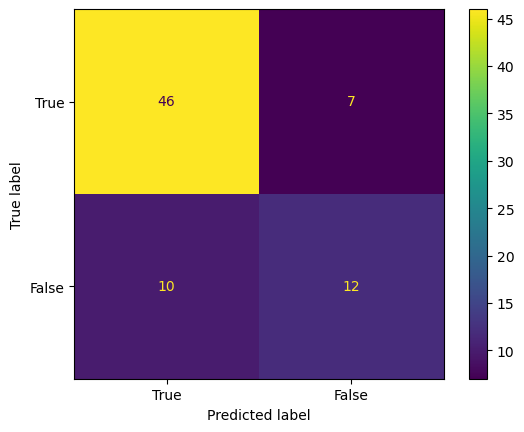

In [12]:
knn = KNeighborsClassifier()

parameters = {
    "classifier__n_neighbors": list(range(1, 31)),
    "classifier__metric": ['euclidean','manhattan'],
    "classifier__weights":['uniform','distance']
}

knn_cls = grid_search(knn, SCALER, parameters)

knn_cls.fit(X_train, y_train)

print(knn_cls.best_estimator_.get_params()['classifier'])

knn_avg, knn_cm = validate(knn_cls, X_val, y_val)
writer.add_scalars("knn", knn_avg)
writer.flush()

## Random Forest

RandomForestClassifier(max_depth=40, max_features='log2', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=690)
              precision    recall  f1-score   support

           0       0.82      0.85      0.83        53
           1       0.60      0.55      0.57        22

    accuracy                           0.76        75
   macro avg       0.71      0.70      0.70        75
weighted avg       0.75      0.76      0.76        75



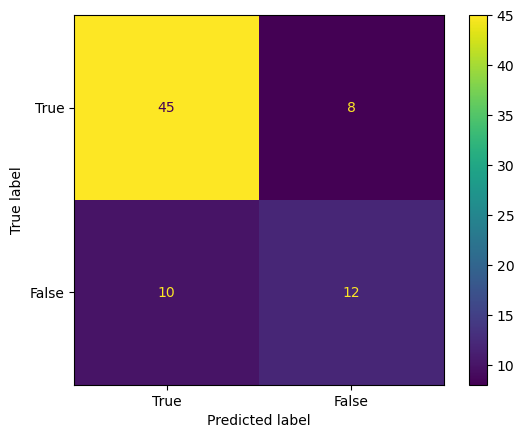

In [13]:
random_forest = RandomForestClassifier(random_state = RANDOM_STATE)

# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
parameters = {
    
    "classifier__n_estimators": [int(x) for x in np.linspace(start = 100, stop = 1000, num = 100)],
    "classifier__max_features": ['log2', 'sqrt'],
    "classifier__max_depth" : [int(x) for x in np.linspace(10, 110, num = 11)],
    "classifier__min_samples_split": [2,5,10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__bootstrap": [True, False],
}

random_forest_cls = halving_random_search(random_forest, SCALER, parameters)

random_forest_cls.fit(X_train, y_train)

print(random_forest_cls.best_estimator_.get_params()['classifier'])

random_forest_avg, random_forest_cm = validate(random_forest_cls, X_val, y_val)
writer.add_scalars("random_forest", random_forest_avg)
writer.flush()

## Logistic Regression

c:\Users\britta\anaconda3\envs\nnlm\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        50
           1       0.52      0.52      0.52        25

    accuracy                           0.68        75
   macro avg       0.64      0.64      0.64        75
weighted avg       0.68      0.68      0.68        75



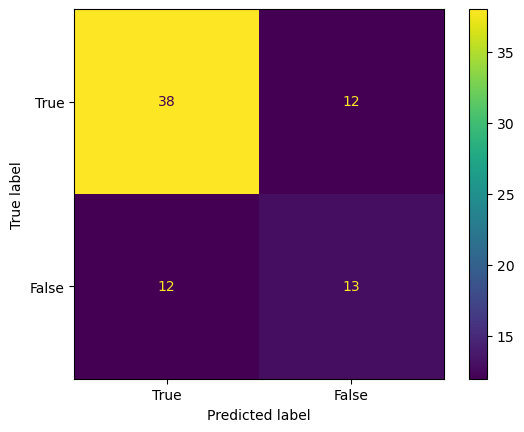

In [25]:
log_reg = LogisticRegression()

parameters = {
    "classifier__penalty": [None, "l2"]
}

reg_cls = grid_search(log_reg, SCALER, parameters)

reg_cls.fit(X_train, y_train)

print(reg_cls.best_estimator_.get_params()['classifier'])

log_reg_avg, log_reg_cm = validate(reg_cls, X_val, y_val)
writer.add_scalars("log_reg", log_reg_avg)
writer.flush()

## SVM

{'classifier__C': [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0], 'classifier__gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'classifier__kernel': ['linear', 'rbf', 'sigmoid']}
SVC(C=0.2, gamma=0.1, kernel='linear')
              precision    recall  f1-score   support

           0       0.75      0.78      0.76        50
           1       0.52      0.48      0.50        25

    accuracy                           0.68        75
   macro avg       0.64      0.63      0.63        75
weighted avg       0.67      0.68      0.68        75



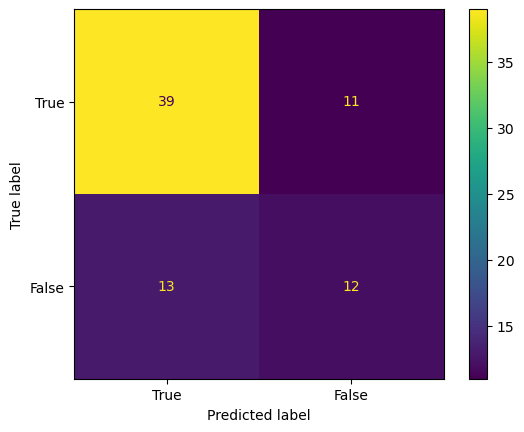

In [28]:
from sklearn.svm import SVC

svm = SVC()

parameters = {
    "classifier__C": [round(i*0.2, 1) for i in range(1, 11)],
    "classifier__gamma": [round(i*0.1, 1) for i in range(1, 11)],
    "classifier__kernel": ["linear", "rbf", "sigmoid"]
}
print(parameters)


svm_cls = grid_search(svm, SCALER, parameters)
svm_cls.fit(X_train, y_train)
print(svm_cls.best_estimator_.get_params()['classifier'])

svm_avg, svm_cm = validate(svm_cls, X_val, y_val)
writer.add_scalars("svm", svm_avg)
writer.flush()

## MLP

{'classifier__solver': ['adam', 'sgd'], 'classifier__activation': ['relu', 'tanh', 'logistic'], 'classifier__learning_rate_init': [0.0001, 0.001, 0.01, 0.005], 'classifier__hidden_layer_sizes': [[10, 10], [100, 10], [50, 100, 50], [100], [10]]}
MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=[100],
              learning_rate_init=0.01, max_iter=30000, random_state=17)
MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=[100],
              learning_rate_init=0.01, max_iter=30000, random_state=17)
MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=[100],
              learning_rate_init=0.01, max_iter=30000, random_state=17)
MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=[100],
              learning_rate_init=0.01, max_iter=30000, random_state=17)
MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=[100],
              learning_rate_init=0.01, max_iter=30000, random_state

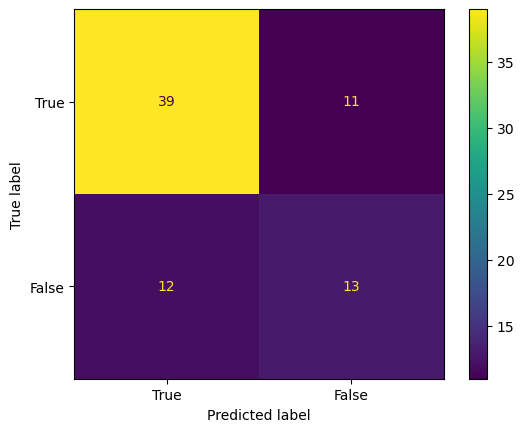

In [29]:
from sklearn.neural_network import MLPClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV


mlp = MLPClassifier(activation='relu', #relu
                    solver='adam', 
                    max_iter=30000, #300000
                    batch_size='auto',
                    learning_rate_init=0.001,
                    # Early stopping kinda does CV too https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
                    # But got worse results
                    early_stopping=True, # False
                    shuffle=True,
                    random_state=17,
                    alpha=0.0001, # L2 loss strenght
                    beta_1=0.9, # 0.9 org Exponential decay rate for estimates of first moment vector in adam
                    beta_2=0.999, # 0.999 org Exponential decay rate for estimates of second moment vector in adam
                    epsilon=1e-8 # 1e-8 org Value for numerical stability in adam.
                    )

"""
# These found acc: 77 f1 74,76
# MLPClassifier(batch_size=64, beta_1=0.93, beta_2=0.99, epsilon=1.2e-08, max_iter=30000, random_state=17, solver='sgd')
parameters = {
    "classifier__solver": ["adam", "sgd"],
    "classifier__batch_size": [4, 16, 32, 64],
    "classifier__activation": ["relu", "tanh", "logistic"],
    "classifier__learning_rate_init": [0.0001, 0.001, 0.01, 0.005],
}

# These found acc 75, f1 72, 75
# MLPClassifier(beta_1=0.09, beta_2=0.988, epsilon=1.2e-08, hidden_layer_sizes=[10], max_iter=30000, random_state=17)
parameters = {
    "classifier__hidden_layer_sizes": [[10,10], [100,10], [50,100,50], [100], [10]],
    "classifier__beta_1": [round(i*0.001, 3) for i in range(90, 95)],
    "classifier__beta_2": [round(i*0.001, 4) for i in range(985, 999, 3)]
}
"""
parameters = {
    "classifier__solver": ["adam", "sgd"],
    #"classifier__batch_size": [4, 16, 32, 64],
    "classifier__activation": ["relu", "tanh", "logistic"],
    "classifier__learning_rate_init": [0.0001, 0.001, 0.01, 0.005],
    "classifier__hidden_layer_sizes": [[10,10], [100,10], [50,100,50], [100], [10]],
    #"classifier__beta_1": [round(i*0.001, 3) for i in range(90, 95)],
    #"classifier__beta_2": [round(i*0.001, 4) for i in range(985, 999, 3)]
}
print(parameters)
for i in range(5):
    mlp_cls = grid_search(mlp, SCALER, parameters)

    mlp_cls.fit(X_train, y_train)

    print(mlp_cls.best_estimator_.get_params()['classifier'])

mlp_avg, mlp_cm = validate(mlp_cls, X_val, y_val)
writer.add_scalars("mlp", mlp_avg)
writer.flush()
writer.close()

In [30]:
%load_ext tensorboard
%tensorboard --logdir=logs